In [3]:
from eda_import import *

from utils.parse_gtf_utils import extract_info

In [4]:
def fisher_exact_wrapper(row):
    contingency_table = np.array([
            [row.N_on, row.N_off],
            [row.T_on, row.T_off]])
    _, pval = stats.fisher_exact(contingency_table)
    return pval

In [5]:
def calc_fisher_exact_pval(grp):
    count_by_sstype = lambda grp: grp[['sstype', 'analysis_id']].drop_duplicates().sstype.value_counts().astype(int)
    
    if grp.sstype.unique().shape[0] == 1:
        return
    sample_counts = count_by_sstype(grp).to_dict()
    # These are the numbers of samples that have at least on mclv sites detected for this gene
    num_normal = sample_counts['normal']
    num_tumour = sample_counts['tumour']

    grped_by_mclv_site = grp.groupby(['mkid', 'mclv', 'strand', 'aclv'])
    # calculate the number of normal or tumour samples that have a mclv site
    count_df = grped_by_mclv_site.apply(lambda g: count_by_sstype(g).to_frame().sort_index().T)
    count_df.fillna(0, inplace=True)
    
    # rename cols and add off cols, preparing for input for Fishers exact test
    count_df.rename(columns={'normal': 'N_on', 'tumour': 'T_on'}, inplace=True)
    count_df['N_off'] = num_normal - count_df['N_on']
    count_df['T_off'] = num_tumour - count_df['T_on']
    count_df['fisher_exact_p'] = count_df.apply(fisher_exact_wrapper, axis=1)
    
    # add other helpful cols
    count_df['N_base'] = num_normal
    count_df['T_base'] = num_tumour
    count_df['N_on_ratio'] = count_df['N_on'] / num_normal
    count_df['T_on_ratio'] = count_df['T_on'] / num_tumour
    
    # from normal to tumour, does the on ratio go up?
    count_df['N2T_ratio_diff'] = count_df['T_on_ratio'] - count_df['N_on_ratio']
    count_df['diff_is_significant'] = count_df.apply(lambda row: True if row.fisher_exact_p < PVAL_CUTOFF else False, axis=1)
    count_df['N2T_ratio_change'] = count_df.apply(lambda row: 'up' if row['N2T_ratio_diff'] > 0 else 'down', axis=1)
    count_df['N2T_ratio_change_sig'] = count_df.apply(lambda row: row.N2T_ratio_change if row.fisher_exact_p < PVAL_CUTOFF else None, axis=1)
    return count_df

In [6]:
def has_diff_aca(grp):
    # it means for all mclv sites with pval < cutoff, and there are both an increase and a decrease
    return grp.query('fisher_exact_p < {0}'.format(PVAL_CUTOFF)).N2T_ratio_change.unique().shape[0] > 1

In [7]:
# diseases with sufficient normal samples (>= 15)
NT_diseases = ['BRCA', 'KIRC', 'COAD', 'KICH', 
               'KIRP', 'LIHC', 'LUAD', 'LUSC',
               'THCA', 'HNSC', 'STAD', 'UCEC',
               'PRAD', 'BLCA']

In [9]:
# Load RPKMS
df_expr = pd.read_csv('./results_data/RPKMS.csv.gz', compression='gzip')

In [10]:
PVAL_CUTOFF = 0.01

In [12]:
%%time
_cols = ['analysis_id', 'barcode', 'disease', 'sstype', 'mkid',
         'gene_name', 'strand', 'participant_id', 'mclv', 'aclv']
adf = pd.read_csv('./results_data/all_cba.KLEAT.on-target-cleaned.filtered.clustered.csv.gz',
                  usecols=_cols)

CPU times: user 24.6 s, sys: 570 ms, total: 25.2 s
Wall time: 25.2 s


In [16]:
# dedup is required after clustering to work on mclv
assert adf.shape[0] == 3420253

adf_dedup = adf.drop_duplicates()

assert adf_dedup.shape[0] == 2213818

assert adf_dedup.gene_name.unique().shape[0] == 114

In [17]:
bdf = adf_dedup.query('disease in {0}'.format(NT_diseases))

In [18]:
bdf.head(1)

,gene_name,strand,analysis_id,barcode,disease,participant_id,mclv,aclv,sstype,mkid
0,ABL1,+,1d811d54-caa1-41f3-bfc2-400eebdd97ef,TCGA-KN-8425-01A-11R-2315-07,KICH,cc316faf-dcb1-4dea-b8b0-a17d000ff40f,133763062,133763062,tumour,chr9|ABL1|+|133763062


In [19]:
%time raw_pval_df = bdf.groupby(['disease', 'gene_name']).apply(calc_fisher_exact_pval)

CPU times: user 1min 35s, sys: 2.77 s, total: 1min 38s
Wall time: 1min 38s


In [20]:
raw_pval_df.query('N_on_ratio < 0.01').query('T_on_ratio < 0.01').reset_index().head()

,disease,gene_name,mkid,mclv,strand,aclv,level_6,N_on,T_on,N_off,T_off,fisher_exact_p,N_base,T_base,N_on_ratio,T_on_ratio,N2T_ratio_diff,diff_is_significant,N2T_ratio_change,N2T_ratio_change_sig
0,BLCA,AKT1,chr14|AKT1|-|105230220,105230220,-,105235686,sstype,0.0,1.0,19.0,413.0,1.0,19,414,0.0,0.002415,0.002415,False,up,None
1,BLCA,ALK,chr2|ALK|-|29737056,29737056,-,29443735,sstype,0.0,1.0,8.0,114.0,1.0,8,115,0.0,0.008696,0.008696,False,up,None
2,BLCA,ALK,chr2|ALK|-|29743239,29743239,-,29443735,sstype,0.0,1.0,8.0,114.0,1.0,8,115,0.0,0.008696,0.008696,False,up,None
3,BLCA,APC,chr5|APC|+|112116697,112116697,+,112178452,sstype,0.0,1.0,18.0,378.0,1.0,18,379,0.0,0.002639,0.002639,False,up,None
4,BLCA,APC,chr5|APC|+|112170731,112170731,+,112178452,sstype,0.0,3.0,18.0,376.0,1.0,18,379,0.0,0.007916,0.007916,False,up,None


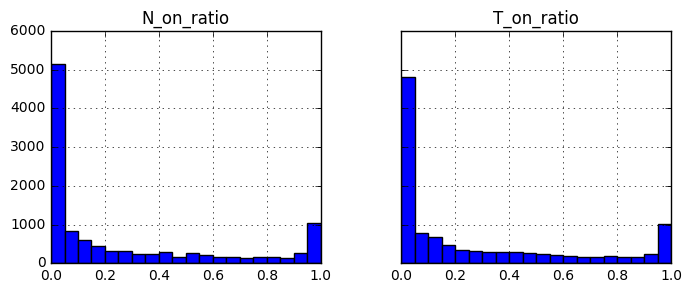

In [30]:
# distribution of on_ratio in N/T sample groups
_ = raw_pval_df[['N_on_ratio', 'T_on_ratio']].hist(
    bins=np.arange(0, 1.01, 0.05), figsize=(8, 3), sharex=True, sharey=True)

Remarkably similar overall.

In [31]:
pval_df = raw_pval_df.reset_index().rename(
    columns={'level_2': 'mkid', 'level_3': 'mclv', 'level_4':'strand', 'level_5': 'aclv'}
).drop('level_6', axis=1)

In [32]:
pval_df.head(2)

,disease,gene_name,mkid,mclv,strand,aclv,N_on,T_on,N_off,T_off,fisher_exact_p,N_base,T_base,N_on_ratio,T_on_ratio,N2T_ratio_diff,diff_is_significant,N2T_ratio_change,N2T_ratio_change_sig
0,BLCA,ABL1,chr9|ABL1|+|133589972,133589972,+,133763062,1.0,23.0,18.0,382.0,1.0,19,405,0.052632,0.05679,0.004159,False,up,None
1,BLCA,ABL1,chr9|ABL1|+|133763062,133763062,+,133763062,19.0,405.0,0.0,0.0,1.0,19,405,1.000000,1.00000,0.000000,False,down,None


In [33]:
for col in ['N_on', 'N_off', 'T_on', 'T_off']:
    pval_df[col] = pval_df[col].astype(int)

In [35]:
%%time 
# aca (alternative cleavage) is an old name used to mean APA
aca_df = pval_df.groupby(['disease', 'gene_name'])\
    .apply(has_diff_aca)\
    .to_frame(name='has_diff_aca')\
    .reset_index()

CPU times: user 4.5 s, sys: 66.7 ms, total: 4.57 s
Wall time: 4.49 s


In [36]:
aca_df = pval_df.merge(aca_df, on=['disease', 'gene_name'])

In [37]:
aca_df.head(1)

,disease,gene_name,mkid,mclv,strand,aclv,N_on,T_on,N_off,T_off,fisher_exact_p,N_base,T_base,N_on_ratio,T_on_ratio,N2T_ratio_diff,diff_is_significant,N2T_ratio_change,N2T_ratio_change_sig,has_diff_aca
0,BLCA,ABL1,chr9|ABL1|+|133589972,133589972,+,133763062,1,23,18,382,1.0,19,405,0.052632,0.05679,0.004159,False,up,None,False


In [38]:
num_reported_genes = aca_df.query('has_diff_aca == True').gene_name.unique().shape[0]
num_reported_cases = aca_df.query('has_diff_aca == True')[['gene_name', 'disease']].drop_duplicates().shape[0]
print(num_reported_genes, num_reported_cases)

33 77


# Estimate FDR

1. Obtain gene-cancer-pair-level (gc-level) p value upper bound by multiplying the lowest two p-values correspond to a significant increase and a significant decrease for each pairs.
1. for those `has_diff_aca` set to false, their gc-level p-value set to 0, since they are not reported anyway. But we need them to do Benjamini Hochberg adjustment

In [39]:
def calc_pc_level_p(grp):
    assert len(set(grp.has_diff_aca.values)) == 1 # make sure there is only one possibility
    if grp.has_diff_aca.all():
        sig_inc_p = grp.query('N2T_ratio_diff > 0').fisher_exact_p.min()
        sig_dec_p = grp.query('N2T_ratio_diff < 0').fisher_exact_p.min()
        return sig_inc_p * sig_dec_p
    else:
        return 1

In [40]:
gc_level_pvals = aca_df.groupby(['gene_name', 'disease']).apply(calc_pc_level_p).sort_values()

In [41]:
# sanity check
assert gc_level_pvals[gc_level_pvals < 1].shape[0] == num_reported_cases

In [43]:
# num_genes * num_diseases tested, actually it should've been three cases less 
# because the three gene-cancer type pairs have not CSs detected in their normal
# sample groups, thus cannot do tumor-specific APA analysis
# but it makes little difference in terms of the FDR estimation
total_num_tests = 114 * 14

In [44]:
gc_level_pvals_df = gc_level_pvals.to_frame(name='gc_level_pval')
gc_level_pvals_df['rank'] = np.arange(1, gc_level_pvals_df.shape[0] + 1)

In [45]:
gc_level_pvals[gc_level_pvals < 1].max()

8.324790830353091e-05

In [46]:
# q_star as defined in the BH paper, https://www.jstor.org/stable/2346101
q_star = (gc_level_pvals_df.gc_level_pval * total_num_tests / gc_level_pvals_df['rank'])[::-1]

In [47]:
# cap at 1 as probability cannot exceed one
q_star = np.minimum(np.ones_like(q_star), q_star)

In [48]:
q_star = np.minimum.accumulate(q_star)

In [49]:
gc_level_pvals_df['fdr_upper_bound'] = q_star

In [50]:
gc_level_pvals_df.query('gc_level_pval < 1').fdr_upper_bound.describe()

count    7.700000e+01
mean     9.578885e-05
std      2.696823e-04
min      6.451290e-36
25%      3.559475e-10
50%      2.450215e-06
75%      5.104204e-05
max      1.725502e-03
Name: fdr_upper_bound, dtype: float64

The estimated FDR is ~0.0017, less than 0.002, so we obtain an upper bound FDR of 0.002, sufficiently small.

# Back to characterizing the identified gene-cancer type pairs

In [51]:
# number of significantly changed CSs within a gene-cancer type pair
num_sig_change_clv = aca_df\
    .query('has_diff_aca == True')\
    .groupby(['disease', 'gene_name'])\
    .apply(lambda g: g.query('diff_is_significant').shape[0])

In [52]:
num_sig_change_clv.shape

(77,)

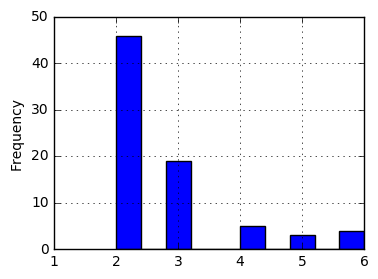

In [57]:
ax = num_sig_change_clv.plot.hist(figsize=(4, 3))
_ = ax.set_xticks(np.arange(1, 7, 1))
ax.grid()

Nothing at one because of the requirement of co-occurrence for reporting tumor-specific APA cases,

In [58]:
num_sig_change_clv[num_sig_change_clv > 2].shape[0]

31

In [59]:
31 / 77

0.4025974025974026

So 31/77 cases report here have more than 2 CSs that undergo significant change cases 

# Analyze recurrence

In [60]:
cases_df = aca_df.query('has_diff_aca == True')[['disease', 'gene_name']].drop_duplicates()

In [63]:
cases_df.gene_name.value_counts().to_frame().T

,CDKN2A,EZH2,CCNE1,FGFR2,WT1,FGF2,BRCA1,MITF,AKT2,NFE2L2,CHURC1,KRAS,HNF1A,GNAS,FLT3,DRAM1,RNF43,MAX,MET,PTCH1,KIT,NFE2L3,CDKN2C,MYCL,APC,MDM4,RB1,ATM,SUFU,SOX2,AMER1,NF1,ALK
gene_name,8,7,6,4,4,4,4,3,3,3,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [64]:
_count = cases_df.gene_name.value_counts()
_count[_count > 1].shape

(18,)

So 18 genes have recurrence across different cancer types

In [66]:
cases_df.shape

(77, 2)

In [67]:
cases_df.gene_name.unique().shape

(33,)

In [68]:
cases_df.disease.unique().shape

(13,)

Of 14 `NT_diseases`, no tumor-specific APA cases are found in STAD

#### Check a few genes in more detail

In [70]:
cases_df.query('gene_name =="FGF2"')

,disease,gene_name
1064,BRCA,FGF2
6294,LUAD,FGF2
7150,LUSC,FGF2
7972,PRAD,FGF2


In [71]:
aca_df.query('gene_name == "CCNE1"').mkid.unique()

array(['chr19|CCNE1|+|30314898', 'chr19|CCNE1|+|30315134',
       'chr19|CCNE1|+|30315215', 'chr19|CCNE1|+|30314486'], dtype=object)

In [72]:
lean_aca_df = aca_df[['gene_name', 'has_diff_aca', 'disease']].drop_duplicates()

In [73]:
lean_aca_df.query('has_diff_aca == True').gene_name.unique().shape

(33,)

In [74]:
lean_aca_df.query('has_diff_aca == True')[['gene_name', 'disease']].drop_duplicates().shape

(77, 2)

In [75]:
lean_aca_df.query('gene_name == "FGF2"').sort_values('has_diff_aca').T

,251,1911,2658,3403,4061,4838,5537,8926,10046,10867,1064,6294,7150,7972
gene_name,FGF2,FGF2,FGF2,FGF2,FGF2,FGF2,FGF2,FGF2,FGF2,FGF2,FGF2,FGF2,FGF2,FGF2
has_diff_aca,False,False,False,False,False,False,False,False,False,False,True,True,True,True
disease,BLCA,COAD,HNSC,KICH,KIRC,KIRP,LIHC,STAD,THCA,UCEC,BRCA,LUAD,LUSC,PRAD


In [76]:
aca_df.query('gene_name == "CCNE1"').query('disease == "KIRP"').sort_values('mclv')

,disease,gene_name,mkid,mclv,strand,aclv,N_on,T_on,N_off,T_off,fisher_exact_p,N_base,T_base,N_on_ratio,T_on_ratio,N2T_ratio_diff,diff_is_significant,N2T_ratio_change,N2T_ratio_change_sig,has_diff_aca
4707,KIRP,CCNE1,chr19|CCNE1|+|30314898,30314898,+,30314918,4,37,24,198,1.000000,28,235,0.142857,0.157447,0.014590,False,up,None,True
4708,KIRP,CCNE1,chr19|CCNE1|+|30315134,30315134,+,30315119,21,108,7,127,0.004592,28,235,0.750000,0.459574,-0.290426,True,down,down,True
4709,KIRP,CCNE1,chr19|CCNE1|+|30315215,30315215,+,30315214,12,167,16,68,0.004500,28,235,0.428571,0.710638,0.282067,True,up,up,True


In [77]:
lean_aca_df.query('gene_name == "CCNE1"').sort_values('has_diff_aca').T

,106,1781,3295,3918,7823,8682,9889,10746,913,2505,4707,5410,6133,6994
gene_name,CCNE1,CCNE1,CCNE1,CCNE1,CCNE1,CCNE1,CCNE1,CCNE1,CCNE1,CCNE1,CCNE1,CCNE1,CCNE1,CCNE1
has_diff_aca,False,False,False,False,False,False,False,False,True,True,True,True,True,True
disease,BLCA,COAD,KICH,KIRC,PRAD,STAD,THCA,UCEC,BRCA,HNSC,KIRP,LIHC,LUAD,LUSC


In [78]:
lean_aca_df.query('gene_name == "RNF43"').sort_values('has_diff_aca').T

,682,1558,2290,3086,3731,5219,5924,6755,7603,8389,9594,10515,4494,11257
gene_name,RNF43,RNF43,RNF43,RNF43,RNF43,RNF43,RNF43,RNF43,RNF43,RNF43,RNF43,RNF43,RNF43,RNF43
has_diff_aca,False,False,False,False,False,False,False,False,False,False,False,False,True,True
disease,BLCA,BRCA,COAD,HNSC,KICH,KIRP,LIHC,LUAD,LUSC,PRAD,STAD,THCA,KIRC,UCEC


In [79]:
lean_aca_df.query('gene_name == "CDKN2A"').sort_values('has_diff_aca').T

,126,939,6157,7016,8708,10763,1795,2528,3308,3937,4724,5426,7847,9915
gene_name,CDKN2A,CDKN2A,CDKN2A,CDKN2A,CDKN2A,CDKN2A,CDKN2A,CDKN2A,CDKN2A,CDKN2A,CDKN2A,CDKN2A,CDKN2A,CDKN2A
has_diff_aca,False,False,False,False,False,False,True,True,True,True,True,True,True,True
disease,BLCA,BRCA,LUAD,LUSC,STAD,UCEC,COAD,HNSC,KICH,KIRC,KIRP,LIHC,PRAD,THCA


In [80]:
lean_aca_df.query('gene_name == "EZH2"').sort_values('has_diff_aca').T

,232,1893,2640,3388,7130,8889,10853,1046,4042,4819,5518,6273,7954,10026
gene_name,EZH2,EZH2,EZH2,EZH2,EZH2,EZH2,EZH2,EZH2,EZH2,EZH2,EZH2,EZH2,EZH2,EZH2
has_diff_aca,False,False,False,False,False,False,False,True,True,True,True,True,True,True
disease,BLCA,COAD,HNSC,KICH,LUSC,STAD,UCEC,BRCA,KIRC,KIRP,LIHC,LUAD,PRAD,THCA


# Add stop codon info to aca_df

In [81]:
# clv_sc_df = pd.read_csv('/projects/btl/zxue/tasrkleat-TCGA-results/hexamer-patch/extracted-annotated-clv-sc-mapping-window-20bp-PC-NMD-v4.csv')
clv_sc_df = pd.read_csv('./reference_data/annotated-clv-sc-mapping.csv.gz', compression='gzip')
# 642 => 632: removed transcripts from ['HG122_PATCH', 'HG1257_PATCH']
assert clv_sc_df.shape[0] == 632

In [82]:
aca_genes_df = clv_sc_df.query('gene_name in {0}'.format(aca_df.query('has_diff_aca == True').gene_name.unique().tolist()))
num_sc_df = aca_genes_df.groupby('gene_name').apply(lambda g: g.sc.unique().shape[0])

In [83]:
num_sc_df[num_sc_df > 1].shape[0]

28

In [84]:
num_sc_df[num_sc_df > 1].shape[0] / num_sc_df.shape[0]

0.8484848484848485

In [85]:
clv_sc_df.drop(['transcript_id', 'clv'], axis=1, inplace=True)
clv_sc_df.drop_duplicates(inplace=True)
clv_sc_df.reset_index(drop=True, inplace=True)

In [86]:
# window = 15 bp
assert clv_sc_df.shape[0] == 561

In [87]:
clv_sc_df.head(1)

,gene_name,seqname,source,sc,strand,gene_source,transcript_source,is_cds_end_NF,is_cds_start_NF,utr_beg,cluster_idx,aclv,clv0,hexamer,hexamer_id,hexamer_loc0,hexamer_loc,sdist_aclv2ahex
0,ABL1,9,protein_coding,133761070,+,ensembl_havana,ensembl_havana,False,False,133761071,1,133763062,133763061,AATAAA,1,133763038,133763039,23.0


In [90]:
clv_sc_df.source.value_counts()

protein_coding             457
nonsense_mediated_decay    104
Name: source, dtype: int64

In [91]:
assert clv_sc_df.gene_name.unique().shape[0] == 114

In [92]:
# ANNOT_GENE2CLV_DD = clv_sc_df.groupby(['gene_name']).apply(lambda g: g.aclv.unique())
ANNOT_CLV2SC_DD = clv_sc_df.groupby(['gene_name', 'aclv']).apply(
    lambda g: np.sort(g.sc.unique())).to_dict()
ANNOT_CLV2SRC_DD = clv_sc_df.groupby(['gene_name', 'aclv']).apply(
    lambda g: np.sort(g.source.unique())).to_dict()

# def map_mclv2aclv(row):
#     """map KLEAT predicted clv to a closest annotated clv"""
#     gene = row.gene_name
#     mclv = row['mclv']
#     poss_aclvs = ANNOT_GENE2CLV_DD[gene]
#     return poss_aclvs[np.argmin(np.abs(poss_aclvs - mclv))]
# cdf['aclv2'] = cdf.apply(map_mclv2aclv, axis=1)
# cdf['dist_mclv2aclv'] = np.abs(cdf['mclv'].values - cdf['aclv'].values)

def map_aclv2sc(row):
    """with aclv assigned, now add the corresponding annotated stop codon information"""
    # ('gene_name', 'aclv') acts like a shorter kid (skid)
    skid = (row.gene_name, row.aclv)
    scs = ANNOT_CLV2SC_DD[skid]
    return tuple(scs.tolist())

def map_aclv2src(row):
    """with aclv assigned, now add the corresponding annotated stop codon information"""
    # ('gene_name', 'aclv') acts like a shorter kid (skid)
    skid = (row.gene_name, row.aclv)
    srcs = ANNOT_CLV2SRC_DD[skid]
    return tuple(srcs.tolist())

In [93]:
aca_df.head(1)

,disease,gene_name,mkid,mclv,strand,aclv,N_on,T_on,N_off,T_off,fisher_exact_p,N_base,T_base,N_on_ratio,T_on_ratio,N2T_ratio_diff,diff_is_significant,N2T_ratio_change,N2T_ratio_change_sig,has_diff_aca
0,BLCA,ABL1,chr9|ABL1|+|133589972,133589972,+,133763062,1,23,18,382,1.0,19,405,0.052632,0.05679,0.004159,False,up,None,False


In [94]:
aca_with_sc_df = aca_df.copy()
# sc: stop codons
aca_with_sc_df['sc_list'] = aca_with_sc_df[['gene_name', 'aclv']].apply(map_aclv2sc, axis=1)
aca_with_sc_df['src_list'] = aca_with_sc_df[['gene_name', 'aclv']].apply(map_aclv2src, axis=1)
aca_with_sc_df['num_sc'] = aca_with_sc_df['sc_list'].apply(len)

aca_with_sc_df['sc_list'] = aca_with_sc_df.sc_list.apply(lambda v: ', '.join(map(str, v)))
aca_with_sc_df['src_list'] = aca_with_sc_df.src_list.apply(lambda v: ', '.join(map(str, v)))

aca_with_sc_df.query('gene_name == "FGF2"').mclv.sort_values().unique()

aca_with_sc_df.query('gene_name == "FGF2"').aclv.sort_values().unique()

aca_with_sc_df.head(1)

aca_with_sc_df.to_csv('./results/aca_pval_with_sc_info.csv', index=False)

In [95]:
_df = aca_with_sc_df.query('has_diff_aca')[['mkid', 'mclv', 'num_sc']].drop_duplicates()
_df.query('num_sc > 1').shape[0]

33

In [96]:
_df.shape[0]

297

In [97]:
33 / 297

0.1111111111111111

So 11% of the predicted CSs in 33 genes are mapped to more than one stop codons

In [98]:
_df = aca_with_sc_df.query('has_diff_aca')

In [99]:
_sr = _df.groupby('gene_name').apply(
    lambda g: g.src_list.str.contains('nonsense_mediated_decay').any())

In [100]:
_sr[_sr].shape[0]

16

In [101]:
16 / 33.

0.48484848484848486

So about half of the reported genes have stop codons involved in NMD

# Multi-trend gene search

In [102]:
comp_between_pairs = lambda row: row.dropna().unique().shape[0] > 1

# if there is at least one cleavage site that shifts differently and significantly between any pair of cancer types,
# then it counts as having multiple shift patterns
def has_multi_trends(grp):
#     print(grp[['disease', 'gene_name']]).drop_duplicates().values
    # check if a gene show different types of significant freq shift trends in different cancer types
    change_df = grp.pivot(index='mclv', columns='disease', values='N2T_ratio_change_sig')
    
    # if a change is not significant for a mclv site in one sstype, then don't use it for comparison at all
    diff = change_df.apply(comp_between_pairs, axis=1)
    return diff.values.any()

In [103]:
aca_df.columns

Index(['disease', 'gene_name', 'mkid', 'mclv', 'strand', 'aclv', 'N_on', 'T_on', 'N_off', 'T_off', 'fisher_exact_p', 'N_base', 'T_base', 'N_on_ratio', 'T_on_ratio', 'N2T_ratio_diff', 'diff_is_significant', 'N2T_ratio_change', 'N2T_ratio_change_sig', 'has_diff_aca'], dtype='object')

In [104]:
# mt: multi-trend
mt_df = aca_with_sc_df\
    .query('has_diff_aca == True')\
    .groupby('gene_name')\
    .apply(has_multi_trends)\
    .to_frame(name='has_mt')

In [105]:
mt_df.query('has_mt == True').T

gene_name,CDKN2A,FLT3,HNF1A,NFE2L2,RNF43,WT1
has_mt,True,True,True,True,True,True
